### Question 1
Download the Fashion_MNIST dataset. You can find it on the official Fashion-MNIST website or by using PyTorch's torchvision.datasets module. Split the dataset into training, validation and testing sets. A common split is 80% of the data to train, 10% to validate, and 10% to test scenarios, but you can adjust this as needed. Normalize the images. This involves scaling the pixel values to a range between 0 and 1.


#### b) Write a pre-processing module for all the images.  


In [30]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import os

#Class to handle CSV files
class FashionMNISTCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.labels = self.data.iloc[:, 0].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [3]:
# Path to Fashion MNIST Dataset
train_csv = os.path.join('./Dataset', 'fashion-mnist_train.csv')
test_csv = os.path.join('./Dataset', 'fashion-mnist_test.csv')

# Load datasets
train_dataset = FashionMNISTCSV(csv_file=train_csv, transform=transform)
test_dataset = FashionMNISTCSV(csv_file=test_csv, transform=transform)

# Define the size of each split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print sizes to verify
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 48000
Validation set size: 12000
Test set size: 10000


### Question 2
Implement a MLP for classification. 

#### a) Flatten the images into a single dimensional vector before feeding it to the model.
To flatten the images, we have included a Flatten layer in the forward method of the MLP model.
#### c) Write the Forward pass from scratch. 

In [4]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)    # Second fully connected layer
        self.fc3 = nn.Linear(128, 10)     # Output layer

    def forward(self, x):
        # a. Flatten the images
        x = x.view(-1, 28*28)
        
        # First layer with ReLU activation
        x = torch.relu(self.fc1(x))
        
        # Second layer with ReLU activation
        x = torch.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        
        return x

#model = MLP()


#### d)Write the Backward pass from scratch. 

In [5]:
def backward_pass(model, loss, learning_rate):
    # Zero the gradients
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
    
    # Compute gradients
    loss.backward()
    
    # Update parameters
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


#### e) Write the module for cross entropy loss 

In [6]:
def cross_entropy_loss(output, target):
    # Apply softmax to output
    softmax_output = torch.softmax(output, dim=1)
    
    # Calculate cross-entropy loss
    loss = -torch.sum(target * torch.log(softmax_output))
    return loss


#### f) Experiment with different hyperparameters like number of layers, dropout, objective function, etc. and settle with a combination which performs the best for the given problem

In [7]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[256, 128], output_size=10, dropout_prob=0.0):
        super(MLP, self).__init__()
        layers = []
        current_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
            current_size = hidden_size
        
        layers.append(nn.Linear(current_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the images
        return self.network(x)


In [17]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, criterion):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    final_train_loss = 0.0
    final_val_loss = 0.0
    final_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        final_train_loss = epoch_train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        final_val_loss = val_loss / len(val_loader)
        final_val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.2f}%')
    
    return final_train_loss, final_val_loss, final_val_accuracy


In [19]:
# Hyperparameter configurations
hidden_layer_configs = [
    [256],
    [256, 128],
    [512, 256, 128]
]
dropout_probs = [0.0, 0.2, 0.5]
learning_rates = [0.01, 0.001]
num_epochs = 10

best_val_loss = float('inf')
best_model = None
best_config = {}

results = []
# Experiment with different hyperparameters
for hidden_layers in hidden_layer_configs:
    for dropout_prob in dropout_probs:
        for lr in learning_rates:
            print(f'Experimenting with hidden_layers={hidden_layers}, dropout_prob={dropout_prob}, learning_rate={lr}')
            model = MLP(input_size=28*28, hidden_sizes=hidden_layers, output_size=10, dropout_prob=dropout_prob)
            criterion = nn.CrossEntropyLoss()
            training_loss, val_loss, val_accuracy = train_and_evaluate(model, train_loader, val_loader, num_epochs, lr, criterion)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = {
                    'hidden_layers': hidden_layers,
                    'dropout_prob': dropout_prob,
                    'learning_rate': lr,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy
                }
            result = {
                'hidden_layers': hidden_layers,
                'dropout_prob': dropout_prob,
                'learning_rate': lr,
                'training_loss': training_loss,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            }
            results.append(result)

print(f'Best Configuration: {best_config}')
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

Experimenting with hidden_layers=[256], dropout_prob=0.0, learning_rate=0.01
Epoch [1/10], Training Loss: 484.5413, Validation Loss: 2.2879, Validation Accuracy: 10.65%
Epoch [2/10], Training Loss: 2.2989, Validation Loss: 2.3029, Validation Accuracy: 9.92%
Epoch [3/10], Training Loss: 2.3025, Validation Loss: 2.3027, Validation Accuracy: 9.93%
Epoch [4/10], Training Loss: 2.3026, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [5/10], Training Loss: 2.3025, Validation Loss: 2.3027, Validation Accuracy: 9.79%
Epoch [6/10], Training Loss: 2.3164, Validation Loss: 2.3024, Validation Accuracy: 9.82%
Epoch [7/10], Training Loss: 2.3056, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [8/10], Training Loss: 2.3024, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [9/10], Training Loss: 2.3065, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [10/10], Training Loss: 2.3025, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Experimenting with hidden_lay

Epoch [5/10], Training Loss: 2.3026, Validation Loss: 2.3026, Validation Accuracy: 9.87%
Epoch [6/10], Training Loss: 2.3026, Validation Loss: 2.3027, Validation Accuracy: 9.87%
Epoch [7/10], Training Loss: 2.3026, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [8/10], Training Loss: 2.3026, Validation Loss: 2.3027, Validation Accuracy: 9.78%
Epoch [9/10], Training Loss: 2.3026, Validation Loss: 2.3026, Validation Accuracy: 9.87%
Epoch [10/10], Training Loss: 2.3026, Validation Loss: 2.3026, Validation Accuracy: 9.87%
Experimenting with hidden_layers=[256, 128], dropout_prob=0.2, learning_rate=0.001
Epoch [1/10], Training Loss: 1.2250, Validation Loss: 0.5554, Validation Accuracy: 79.87%
Epoch [2/10], Training Loss: 0.6299, Validation Loss: 0.4894, Validation Accuracy: 82.14%
Epoch [3/10], Training Loss: 0.5591, Validation Loss: 0.4561, Validation Accuracy: 83.12%
Epoch [4/10], Training Loss: 0.5221, Validation Loss: 0.4358, Validation Accuracy: 84.12%
Epoch [5/10], Training

Epoch [10/10], Training Loss: nan, Validation Loss: nan, Validation Accuracy: 10.10%
Experimenting with hidden_layers=[512, 256, 128], dropout_prob=0.5, learning_rate=0.001
Epoch [1/10], Training Loss: 1.8102, Validation Loss: 0.7616, Validation Accuracy: 73.31%
Epoch [2/10], Training Loss: 0.9781, Validation Loss: 0.6305, Validation Accuracy: 76.96%
Epoch [3/10], Training Loss: 0.8369, Validation Loss: 0.5909, Validation Accuracy: 78.25%
Epoch [4/10], Training Loss: 0.7774, Validation Loss: 0.5652, Validation Accuracy: 79.21%
Epoch [5/10], Training Loss: 0.7321, Validation Loss: 0.5490, Validation Accuracy: 79.03%
Epoch [6/10], Training Loss: 0.6973, Validation Loss: 0.5362, Validation Accuracy: 80.62%
Epoch [7/10], Training Loss: 0.6746, Validation Loss: 0.5161, Validation Accuracy: 80.91%
Epoch [8/10], Training Loss: 0.6471, Validation Loss: 0.5103, Validation Accuracy: 82.12%
Epoch [9/10], Training Loss: 0.6330, Validation Loss: 0.4851, Validation Accuracy: 83.11%
Epoch [10/10], Tr

In [27]:
import matplotlib.pyplot as plt

# Function to plot results
def plot_results(results_df):
    for i, result in results_df.iterrows():
        plt.figure(figsize=(12, 4))
        
        # Plot Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.bar(['Train Loss', 'Validation Loss'], [result['training_loss'], result['val_loss']])
        plt.ylabel('Loss')
        plt.title(f"Loss: hidden_layers={result['hidden_layers']}, dropout={result['dropout_prob']}, lr={result['learning_rate']}")
        
        # Plot Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.bar(['Validation Accuracy'], [result['val_accuracy']])
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy: hidden_layers={result['hidden_layers']}, dropout={result['dropout_prob']}, lr={result['learning_rate']}")
        
        plt.tight_layout()
        plt.savefig(f"plot_{i}.png")
        plt.close()

plot_results(results_df)

# Find the best configuration based on validation loss
best_experiment = results_df.loc[results_df['val_loss'].idxmin()]

# Generate HTML report
html = '<html><head><title>Hyperparameter Tuning Report</title></head><body>'
html += '<h1>Hyperparameter Tuning Report</h1>'
html += results_df.to_html()

html += '<h2>Best Experiment</h2>'
html += f'<p>Hidden Layers: {best_experiment["hidden_layers"]}</p>'
html += f'<p>Dropout Probability: {best_experiment["dropout_prob"]}</p>'
html += f'<p>Learning Rate: {best_experiment["learning_rate"]}</p>'
html += f'<p>Training Loss: {best_experiment["training_loss"]:.4f}</p>'
html += f'<p>Validation Loss: {best_experiment["val_loss"]:.4f}</p>'
html += f'<p>Validation Accuracy: {best_experiment["val_accuracy"]:.2f}%</p>'

for i in range(len(results_df)):
    html += f'<h2>Experiment {i+1}</h2>'
    html += f'<img src="plot_{i}.png" alt="Experiment {i+1} Plot">'

html += '</body></html>'

# Save to an HTML file
with open('hyperparameter_tuning_report.html', 'w') as f:
    f.write(html)


## Question 3
Implement a CNN backbone model using pytorch.
#### a) Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer

In [28]:
class CNN_Model(nn.Module):

    #define init function
    def __init__(self):
        super(CNN_Model, self).__init__()

        #input size: 28
        #channel - 1,
        #32 - output channel from this layer,
        #square kerner of size 2.
        #stride defaults to 1 and padding to 0.
        self.layer1_conv = nn.Conv2d(1, 16, 2, padding=0)
        self.layer1_activ = nn.ReLU()
        self.layer1_maxpool = nn.MaxPool2d(2, stride=2) #2x2 kernel

        #layer 2, input size
        self.layer2_conv = nn.Conv2d(16, 16, 2, padding=0)
        self.layer2_activ = nn.ReLU()
        self.layer2_maxpool = nn.MaxPool2d(2, stride=2)
        #layer 3
        self.layer3_conv = nn.Conv2d(16, 16, 2, padding=0)
        self.layer3_activ = nn.ReLU()
        self.layer3_maxpool = nn.MaxPool2d(2, stride=2) #14x14x64
        #layer 4
        self.layer4_conv = nn.Conv2d(16, 16, 2, padding=1)
        self.layer4_activ = nn.ReLU()
        self.layer4_maxpool = nn.MaxPool2d(2, stride=1) #7x7x128
        #layer 5
        self.layer5_conv = nn.Conv2d(16, 16, 2 , padding=1)
        self.layer5_activ = nn.ReLU()
        self.layer5_maxpool = nn.MaxPool2d(2, stride=1) #4x4x256

        #Dense layer, input size=256*

        self.dense1 = nn.Linear(16*2*2, 20)
        #output layer
        self.out = nn.Linear(20, 10)

    def forward(self, x):

        #pass data x through 1st layer
        x = self.layer1_conv(x)
        #print(f"shape of data after layer1_conv: {x.shape}")
        x = self.layer1_activ(x)
        x = self.layer1_maxpool(x)
        #print(f"shape of data after layer1_maxpool: {x.shape}")

        #pass data through 2nd layer
        x = self.layer2_conv(x)
        #print(f"shape of data after layer2_conv: {x.shape}")
        x = self.layer2_activ(x)
        x = self.layer2_maxpool(x)
        #print(f"shape of data after layer2_maxpool: {x.shape}")

        #pass data through 3rd layer
        x = self.layer3_conv(x)
        #print(f"shape of data after layer3_conv: {x.shape}")
        x = self.layer3_activ(x)
        x = self.layer3_maxpool(x)
        #print(f"shape of data after layer3_maxpool: {x.shape}")

        #pass data through 4th layer
        x = self.layer4_conv(x)
        #print(f"shape of data after layer4_conv: {x.shape}")
        x = self.layer4_activ(x)
        x = self.layer4_maxpool(x)
        #print(f"shape of data after layer4_maxpool: {x.shape}")

        #pass data through 5th layer
        x = self.layer5_conv(x)
        #print(f"shape of data after layer5_conv: {x.shape}")
        x = self.layer5_activ(x)
        x = self.layer5_maxpool(x)
        #print(f"shape of data after layer5_maxpool: {x.shape}")
        #print(len(x[1]))
        #print(len(x[1][1]))
        #print(len(x[1][1][1]))
        x = F.dropout(x,0.2)
        #flatten
        x = x.view(-1, 16*2*2)

        #x = self.flatten = torch.flatten(x)
        #This method will return flattened data that will be passed to Dense layer from Q2
        #following 2 lines will be commented after testing.
        #print(f"shape of data after flatten: {x.shape}")
        x = self.dense1(x)
        x = self.out(x)
        return x

In [31]:
#DEBUG:: no need to execute
#This code block was used to determin the size of the image at different layers of the network

#Returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)
random_data = torch.rand((32, 1, 28, 28))

cnn_model = CNN_Model()

output_data = cnn_model(random_data)
#print (output_data)

In [33]:
#DEBUG:: no need to execute
#to calculate total number of trainable parameters in the model
trainable_param = 0

for name, param in cnn_model.named_parameters():
    print(name, param.numel())
    trainable_param += param.numel()

print(f"Total trainable parameters {trainable_param}")

layer1_conv.weight 64
layer1_conv.bias 16
layer2_conv.weight 1024
layer2_conv.bias 16
layer3_conv.weight 1024
layer3_conv.bias 16
layer4_conv.weight 1024
layer4_conv.bias 16
layer5_conv.weight 1024
layer5_conv.bias 16
dense1.weight 1280
dense1.bias 20
out.weight 200
out.bias 10
Total trainable parameters 5750


In [34]:
#DEBUG:: no need to execute
for name, param in cnn_model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: layer1_conv.weight | Size: torch.Size([16, 1, 2, 2]) | Values : tensor([[[[-0.0585,  0.2945],
          [-0.0696, -0.3909]]],


        [[[ 0.1063, -0.2989],
          [ 0.1919,  0.0902]]]], grad_fn=<SliceBackward0>) 

Layer: layer1_conv.bias | Size: torch.Size([16]) | Values : tensor([0.0727, 0.3771], grad_fn=<SliceBackward0>) 

Layer: layer2_conv.weight | Size: torch.Size([16, 16, 2, 2]) | Values : tensor([[[[-0.0490,  0.0907],
          [ 0.0820, -0.0026]],

         [[ 0.0641,  0.0489],
          [-0.1220,  0.0023]],

         [[ 0.0429,  0.0709],
          [ 0.0832,  0.0313]],

         [[ 0.0046,  0.1070],
          [-0.0201, -0.0642]],

         [[-0.0429, -0.0817],
          [-0.0406, -0.1154]],

         [[-0.0666, -0.0817],
          [-0.1088,  0.0588]],

         [[ 0.0805, -0.0347],
          [ 0.1142,  0.1221]],

         [[-0.0599, -0.0171],
          [ 0.0305, -0.0065]],

         [[ 0.0547,  0.0391],
          [ 0.0039,  0.0951]],

         [[ 0.0421,  0.0383],
 

#### b) Experiment with different kernel size, number of kernel each layer (keep number of filter same in each layer, double it in each layer etc) and settle with a combination which performs the best for the given problem

In [35]:
#Function to train the CNN classificaion model
def cnn_model_train(train_dataloader, cnn_model, loss_func, optimizer):
    train_data_size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    batch_size = 32
    #for collecting losses
    train_losses = 0
    #for collecting correct predictions, unused currently.
    train_correct = 0

    #set the model to training mode
    cnn_model.train()

    train_c = 0
    #each epoch will execute this for loop for {training data size}/{batch size}
    for batch, (x_train, y_train) in enumerate(train_dataloader):
      #print(f"Training Batch#::{batch}")
      batch = batch+1
      y_predict = cnn_model(x_train)
      loss = loss_func(y_predict, y_train)

      #backpropagate the prediction loss
      loss.backward()
      #adjust the parameters
      optimizer.step()
      #to reset the gradients of model parameters. Gradients by default add up;
      #to prevent double-counting, we explicitly zero them at each iteration.
      optimizer.zero_grad()

      loss = loss.item()
      #printout training metrics after batch of 100
      if batch % 500 ==0:
        loss, current = loss, batch * batch_size + len(x_train)
        #print(f"Training loss: {loss:>2f}  [{current:>5d}/{train_data_size:>5d}]")
      #sum up training losses
      train_losses += loss
    #average out the losses and return as training loss for an epoch
    train_losses /=num_batches
    return train_losses, train_correct

In [36]:
#Test the model
def cnn_model_test(dataloader, cnn_model, loss_func):
    #set the model to evaluation (important for BN and Dropout layers)
    cnn_model.eval()
    num_batches = len(dataloader)

    #initialize
    valid_losses = 0
    accuracy = 0
    #ensure that no grad are computed during test mode
    with torch.no_grad():
        for batch, (x_valid, y_valid) in enumerate(dataloader):
          #print(f"Validation Batch#::{batch}")
          batch = batch+1
          predict = cnn_model(x_valid)
          #print(f"predict::{predict}")
          #print(f"y_valid::{y_valid}")
          #print(f"predict.argmax(1)::{predict.argmax(1)}")
          #collect values for accuracy measurement
          accuracy += (predict.argmax(1) == y_valid).type(torch.float).sum().item()
          #print(f"Accuracy::{accuracy}")
          valid_loss = loss_func(predict, y_valid)
          valid_loss = valid_loss.item()
          if batch % 500 ==0:
            #valid_loss = valid_loss/num_batches
            #print(f"Validation loss: {valid_loss}")
            pass
          valid_losses += valid_loss
    valid_losses /=  num_batches
    accuracy /= len(dataloader.dataset)
    return valid_losses, accuracy

In [37]:
# Function to plot training and validation loss as one plot and Testing accuracy as another plot.
def plot_losses(train_loss, valid_loss, test_accuracy):
  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(train_loss,'s-',label='Training')
  ax[0].plot(valid_loss,'o-',label='Validation')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Model loss')
  ax[0].legend()

  ax[1].plot(test_accuracy,'x-',label='Model Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Model Accuracy')
  ax[1].legend()
  plt.show()

### Exeucte below block to instantiate three dataloader, this will also instantiate tthe loss function. since this is a classification problem, we will useCrossEntropyLoss

In [42]:
train_dataloader, validation_dataloader, test_dataloader = train_loader,val_loader,test_loader# FMNIST_DataLoader()
loss_func = nn.CrossEntropyLoss()

#### c) Try different weight initialization methods (random, Xavier, He) 

### Below block will
1. initialize model weights using 'Xavier' algorith.
2. invoke training, valiation and testing functions
3. accumulate lossses and accuracy
4. invoke plotting function to plot the loss and accuracy graph

epoch::0, Train_loss::2.716826069752375, Validation_loss::1.045565143861669, Test accuracy::0.6126
epoch::1, Train_loss::0.8820156274636587, Validation_loss::0.7892219249872451, Test accuracy::0.7147
epoch::2, Train_loss::0.7271330848534902, Validation_loss::0.686868854501146, Test accuracy::0.7472
epoch::3, Train_loss::0.6533661849896113, Validation_loss::0.6359675377607346, Test accuracy::0.771
epoch::4, Train_loss::0.6157101118564605, Validation_loss::0.6097750505234333, Test accuracy::0.775
epoch::5, Train_loss::0.5804125145276388, Validation_loss::0.5782970916083519, Test accuracy::0.7911
epoch::6, Train_loss::0.5505871736804644, Validation_loss::0.5518150477808841, Test accuracy::0.7974
epoch::7, Train_loss::0.5293178546031316, Validation_loss::0.5360435352839054, Test accuracy::0.8093
epoch::8, Train_loss::0.511570453008016, Validation_loss::0.5255408508980528, Test accuracy::0.808
epoch::9, Train_loss::0.496545108795166, Validation_loss::0.513729287113281, Test accuracy::0.8189

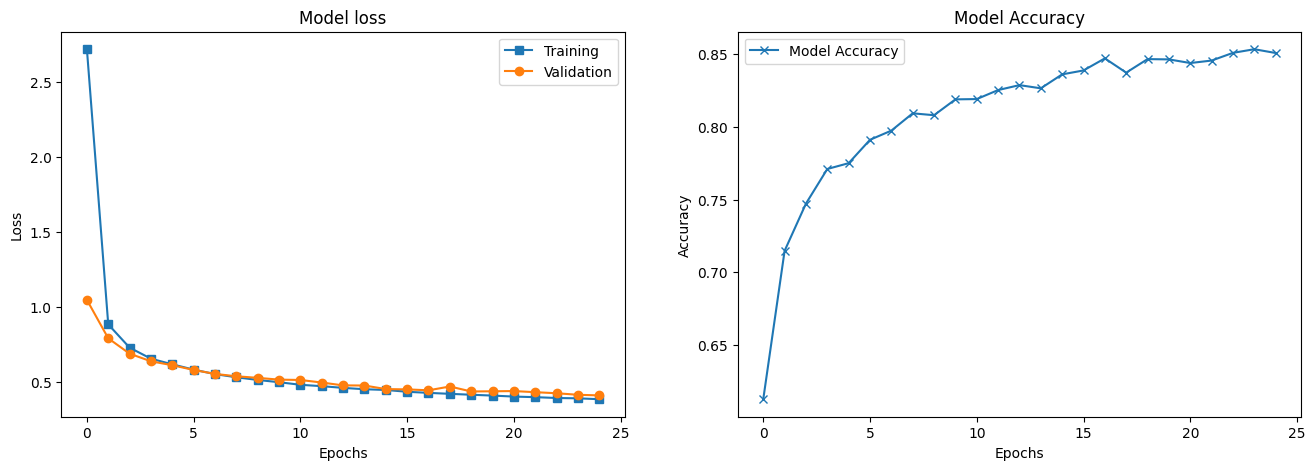

In [43]:
epochs = 25
#instantiate the model weights using Xavier algrithm
cnn_model_xavier = CNN_Model()
for param in cnn_model_xavier.named_parameters():
    #print("PARAM0:",param[0])
    #print("PARAM1:",param[1])
    if 'weight' in param[0]:
        torch.nn.init.xavier_normal_(param[1].data)
#Initialize Optimizer and Loss function
optimizer = torch.optim.Adam(cnn_model_xavier.parameters(), lr=0.0005)
train_loss_arr = []
valid_loss_ar = []
valid_acc = []
test_accuracy = []
#start the training and validation loop
for e in range(epochs):
  train_loss, _ = cnn_model_train(train_dataloader, cnn_model_xavier, loss_func, optimizer)
  valid_loss, valid_acc = cnn_model_test(validation_dataloader, cnn_model_xavier, loss_func)
  test_loss, test_acc = cnn_model_test(test_dataloader, cnn_model_xavier, loss_func)
  test_accuracy.append(test_acc)
  train_loss_arr.append(train_loss)
  valid_loss_ar.append(valid_loss)
  print(f"epoch::{e}, Train_loss::{train_loss}, Validation_loss::{valid_loss}, Test accuracy::{test_acc}")
#plot losses and model accuracy
plot_losses(train_loss_arr, valid_loss_ar, test_accuracy)

### Below block will
1. initialize model weights using 'he (kaiming)' algorith.
2. invoke training, valiation and testing functions
3. accumulate lossses and accuracy
4. invoke plotting function to plot the loss and accuracy graph

epoch::0, Train_loss::21.84333783690135, Validation_loss::1.8567677108531302, Test accuracy::0.4305
epoch::1, Train_loss::1.4580916043917338, Validation_loss::1.21829354921554, Test accuracy::0.5675
epoch::2, Train_loss::1.1043253530661266, Validation_loss::1.0258763885878501, Test accuracy::0.6312
epoch::3, Train_loss::0.9589853435357412, Validation_loss::0.9453554296113075, Test accuracy::0.6565
epoch::4, Train_loss::0.878990571419398, Validation_loss::0.861039437512134, Test accuracy::0.6931
epoch::5, Train_loss::0.8201189963817597, Validation_loss::0.7958340860427694, Test accuracy::0.7172
epoch::6, Train_loss::0.7643891255458196, Validation_loss::0.7717354375314205, Test accuracy::0.7165
epoch::7, Train_loss::0.7253736546039581, Validation_loss::0.7182255178055865, Test accuracy::0.7365
epoch::8, Train_loss::0.7012955195506414, Validation_loss::0.7382012480433952, Test accuracy::0.7344
epoch::9, Train_loss::0.6830766600370407, Validation_loss::0.6738130012725262, Test accuracy::0.

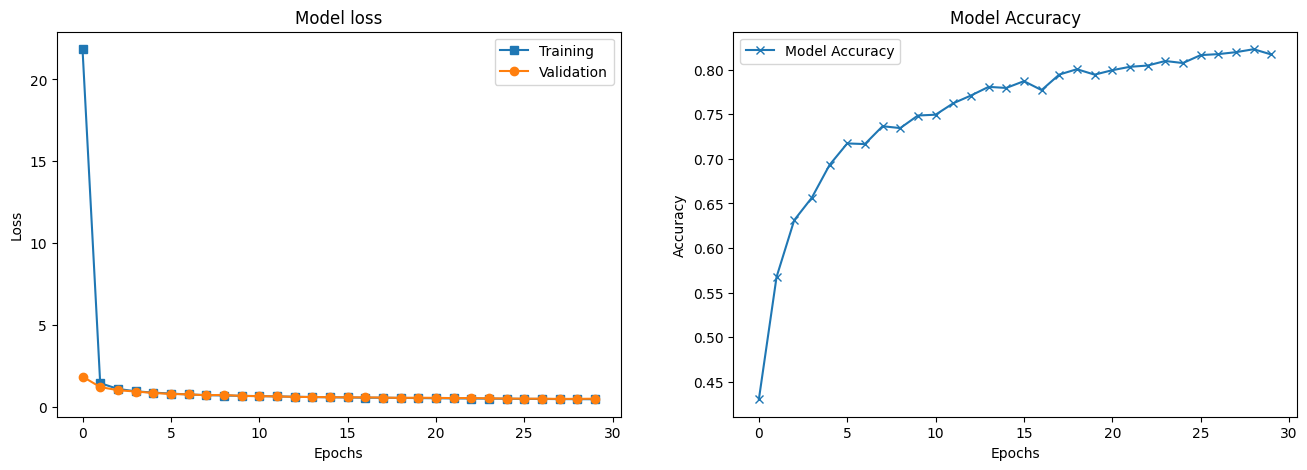

In [44]:
epochs = 30
#instantiate the model weights using 'He' algrithm
cnn_model_he = CNN_Model()
for param in cnn_model_he.named_parameters():
    #print("PARAM0:",param[0])
    #print("PARAM1:",param[1])
    if 'weight' in param[0]:
        #Parameter initialization logic
        torch.nn.init.kaiming_normal_(param[1].data)

#Initialize Optimizer and Loss function
optimizer = torch.optim.Adam(cnn_model_he.parameters(), lr=0.001)
train_loss_arr = []
valid_loss_ar = []
valid_acc = []
test_accuracy = []
#start the training and validation loop
for e in range(epochs):
  train_loss, _ = cnn_model_train(train_dataloader, cnn_model_he, loss_func, optimizer)
  valid_loss, valid_acc = cnn_model_test(validation_dataloader, cnn_model_he, loss_func)
  test_loss, test_acc = cnn_model_test(test_dataloader, cnn_model_he, loss_func)
  test_accuracy.append(test_acc)
  train_loss_arr.append(train_loss)
  valid_loss_ar.append(valid_loss)
  print(f"epoch::{e}, Train_loss::{train_loss}, Validation_loss::{valid_loss}, Test accuracy::{test_acc}")
#plot losses and model accuracy
plot_losses(train_loss_arr, valid_loss_ar, test_accuracy)

### Below block will
1. Randomly initialize model weights
2. invoke training, valiation and testing functions
3. accumulate lossses and accuracy
4. invoke plotting function to plot the loss and accuracy graph

epoch::0, Train_loss::0.8109219133456548, Validation_loss::0.608079491777623, Test accuracy::0.7772
epoch::1, Train_loss::0.556821730852127, Validation_loss::0.5358519145148866, Test accuracy::0.8093
epoch::2, Train_loss::0.5076065115133921, Validation_loss::0.5062313641005374, Test accuracy::0.8125
epoch::3, Train_loss::0.47218322396278384, Validation_loss::0.4740211564175626, Test accuracy::0.8314
epoch::4, Train_loss::0.44677133733034136, Validation_loss::0.4582748072261506, Test accuracy::0.833
epoch::5, Train_loss::0.42822551204760867, Validation_loss::0.4234190531709093, Test accuracy::0.8494
epoch::6, Train_loss::0.41043908125162126, Validation_loss::0.42736135145768206, Test accuracy::0.8408
epoch::7, Train_loss::0.39934256557623543, Validation_loss::0.40474932403006453, Test accuracy::0.8547
epoch::8, Train_loss::0.38936674044529596, Validation_loss::0.40218535604629113, Test accuracy::0.8568
epoch::9, Train_loss::0.37825500065088274, Validation_loss::0.4157694325326605, Test 

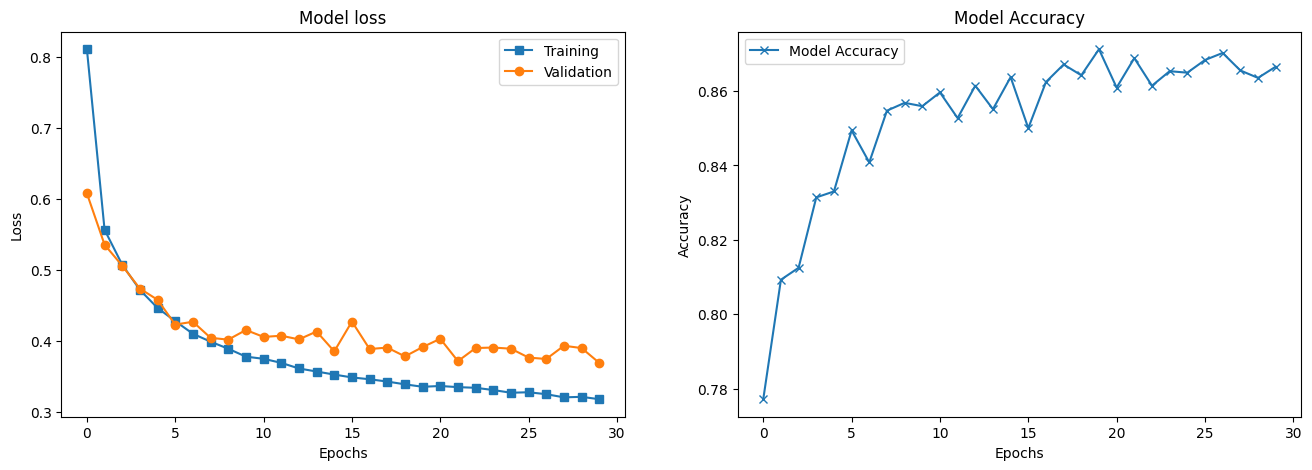

In [46]:
#instantiate the model weights using 'random' initialization
epochs = 30
cnn_model = CNN_Model()
#Initialize Optimizer and Loss function
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
train_loss_arr = []
valid_loss_ar = []
valid_acc = []
test_accuracy = []
for e in range(epochs):
  train_loss, _ = cnn_model_train(train_dataloader, cnn_model, loss_func, optimizer)
  valid_loss, valid_acc = cnn_model_test(validation_dataloader, cnn_model, loss_func)
  test_loss, test_acc = cnn_model_test(test_dataloader, cnn_model, loss_func)
  test_accuracy.append(test_acc)
  train_loss_arr.append(train_loss)
  valid_loss_ar.append(valid_loss)
  print(f"epoch::{e}, Train_loss::{train_loss}, Validation_loss::{valid_loss}, Test accuracy::{test_acc}")
#plot losses and model accuracy
plot_losses(train_loss_arr, valid_loss_ar, test_accuracy)

#### d) After extracting feature from CNN model use MLP for classification

In [49]:
import torch.nn as nn

# Define the MLP model
class MLP_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP_Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Function to extract features from CNN model
def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            outputs = model(inputs)
            features.append(outputs)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

# Get the size of the flattened features from the CNN model
def get_flattened_feature_size(model, input_shape):
    model.eval()
    with torch.no_grad():
        dummy_input = torch.zeros(1, *input_shape)
        output = model(dummy_input)
        flattened_size = output.view(-1).size(0)
    return flattened_size

# Assuming your input images are of shape (channels, height, width)
input_shape = (1, 28, 28)  # Adjust this based on your dataset

# Determine the flattened feature size
flattened_feature_size = get_flattened_feature_size(cnn_model, input_shape)

# Instantiate the MLP model
hidden_size = 100
num_classes = 10  # Adjust this based on your dataset
mlp_model = MLP_Model(flattened_feature_size, hidden_size, num_classes)

# Extract features from the training set using the CNN model
train_features, train_labels = extract_features(train_dataloader, cnn_model)
train_features = train_features.view(train_features.size(0), -1)  # Flatten the features

# Define loss function and optimizer for MLP
mlp_loss_func = nn.CrossEntropyLoss()
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

# Train the MLP model
epochs = 50
for epoch in range(epochs):
    mlp_model.train()
    mlp_optimizer.zero_grad()
    outputs = mlp_model(train_features)
    loss = mlp_loss_func(outputs, train_labels)
    loss.backward()
    mlp_optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Validate the MLP model
val_features, val_labels = extract_features(validation_dataloader, cnn_model)
val_features = val_features.view(val_features.size(0), -1)  # Flatten the features
mlp_model.eval()
with torch.no_grad():
    val_outputs = mlp_model(val_features)
    val_loss = mlp_loss_func(val_outputs, val_labels)
    _, predicted = torch.max(val_outputs.data, 1)
    val_accuracy = (predicted == val_labels).sum().item() / val_labels.size(0)
    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Test the MLP model
test_features, test_labels = extract_features(test_dataloader, cnn_model)
test_features = test_features.view(test_features.size(0), -1)  # Flatten the features
mlp_model.eval()
with torch.no_grad():
    test_outputs = mlp_model(test_features)
    test_loss = mlp_loss_func(test_outputs, test_labels)
    _, predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (predicted == test_labels).sum().item() / test_labels.size(0)
    print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/50], Loss: 4.5435
Epoch [2/50], Loss: 4.2004
Epoch [3/50], Loss: 3.8749
Epoch [4/50], Loss: 3.5657
Epoch [5/50], Loss: 3.2757
Epoch [6/50], Loss: 3.0124
Epoch [7/50], Loss: 2.7823
Epoch [8/50], Loss: 2.5819
Epoch [9/50], Loss: 2.4011
Epoch [10/50], Loss: 2.2318
Epoch [11/50], Loss: 2.0700
Epoch [12/50], Loss: 1.9145
Epoch [13/50], Loss: 1.7654
Epoch [14/50], Loss: 1.6237
Epoch [15/50], Loss: 1.4916
Epoch [16/50], Loss: 1.3714
Epoch [17/50], Loss: 1.2664
Epoch [18/50], Loss: 1.1791
Epoch [19/50], Loss: 1.1106
Epoch [20/50], Loss: 1.0589
Epoch [21/50], Loss: 1.0192
Epoch [22/50], Loss: 0.9858
Epoch [23/50], Loss: 0.9540
Epoch [24/50], Loss: 0.9214
Epoch [25/50], Loss: 0.8877
Epoch [26/50], Loss: 0.8536
Epoch [27/50], Loss: 0.8206
Epoch [28/50], Loss: 0.7897
Epoch [29/50], Loss: 0.7616
Epoch [30/50], Loss: 0.7364
Epoch [31/50], Loss: 0.7138
Epoch [32/50], Loss: 0.6937
Epoch [33/50], Loss: 0.6756
Epoch [34/50], Loss: 0.6593
Epoch [35/50], Loss: 0.6446
Epoch [36/50], Loss: 0.6312
E